# Comparator for countries

This is a WOP of a indicator comparator for countries.
Aka, "What makes your country special ?"

- We extract the metrics for two entities (currently Spain . vs Euro zone)

- Calculate the regression and coisine distance for each metric.

- Display metrics with lower values (Your country behaviour for that metrics is similar)

- Display metrics with higher values (Your country behaviour for that metrics is different)

- Display metrics where your country tops world ranks

In [33]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
from scipy.spatial import distance 
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


pd.set_option("display.width"    , 1000)
pd.set_option("display.max_rows" , 1500)

In [2]:
conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')

In [3]:
CountryCode = 'EMU'
pd.read_sql(f"""SELECT CountryName
               FROM Indicators
               WHERE CountryCode = '{CountryCode}'
               LIMIT 1""",
           conn).values[0][0]


'Euro area'

In [117]:
pd.read_sql(f"""SELECT *
               FROM Indicators
               LIMIT 1""",
           conn)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,133.560907


In [158]:
pd.read_sql("""SELECT distinct(CountryName),CountryCode
               FROM Indicators Where CountryName = 'Spain'
               OR CountryName = 'Euro area' """,
           conn)
pd.read_sql("""SELECT distinct(CountryName),CountryCode
               FROM Indicators order by 1  """,
           conn)

,CountryName,CountryCode
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,ADO
5,Angola,AGO
6,Antigua and Barbuda,ATG
7,Arab World,ARB
8,Argentina,ARG
9,Armenia,ARM


In [107]:
indicators = pd.read_sql("""SELECT distinct(IndicatorName) as indicator
               FROM Indicators Where CountryName = 'Spain' order by 1""",
           conn)

indicators_array = indicators.indicator.values
indicators_array

array(['2005 PPP conversion factor, GDP (LCU per international $)',
       '2005 PPP conversion factor, private consumption (LCU per international $)',
       'Access to electricity (% of population)',
       'Access to electricity, rural (% of rural population)',
       'Access to electricity, urban (% of urban population)',
       'Access to non-solid fuel (% of population)',
       'Access to non-solid fuel, rural (% of rural population)',
       'Access to non-solid fuel, urban (% of urban population)',
       'Adjusted net enrolment rate, primary, both sexes (%)',
       'Adjusted net enrolment rate, primary, female (%)',
       'Adjusted net enrolment rate, primary, male (%)',
       'Adjusted net national income (annual % growth)',
       'Adjusted net national income (constant 2005 US$)',
       'Adjusted net national income (current US$)',
       'Adjusted net national income per capita (annual % growth)',
       'Adjusted net national income per capita (constant 2005 US$)',
 

In [6]:
IndicatorName = 'GDP (constant LCU)'
CountryCode   = 'ESP'

df = pd.read_sql(f"""SELECT IndicatorName,IndicatorCode,Year,Value
               FROM Indicators
               WHERE IndicatorName = '{IndicatorName}' 
                 AND CountryCode   = '{CountryCode}'  """,
           conn)
df


,IndicatorName,IndicatorCode,Year,Value
0,GDP (constant LCU),NY.GDP.MKTP.KN,1960,1.692414e+11
1,GDP (constant LCU),NY.GDP.MKTP.KN,1961,1.892774e+11
2,GDP (constant LCU),NY.GDP.MKTP.KN,1962,2.081170e+11
3,GDP (constant LCU),NY.GDP.MKTP.KN,1963,2.280889e+11
4,GDP (constant LCU),NY.GDP.MKTP.KN,1964,2.401971e+11
5,GDP (constant LCU),NY.GDP.MKTP.KN,1965,2.552169e+11
6,GDP (constant LCU),NY.GDP.MKTP.KN,1966,2.737101e+11
7,GDP (constant LCU),NY.GDP.MKTP.KN,1967,2.855900e+11
8,GDP (constant LCU),NY.GDP.MKTP.KN,1968,3.044305e+11
9,GDP (constant LCU),NY.GDP.MKTP.KN,1969,3.315461e+11


In [7]:
x = df[['Year','Value']].values
length = df.shape[0]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled


array([[0.        , 0.        ],
       [0.01851852, 0.02105548],
       [0.03703704, 0.04085375],
       [0.05555556, 0.06184197],
       [0.07407407, 0.07456622],
       [0.09259259, 0.09035036],
       [0.11111111, 0.10978456],
       [0.12962963, 0.12226902],
       [0.14814815, 0.14206816],
       [0.16666667, 0.17056362],
       [0.18518519, 0.18551395],
       [0.2037037 , 0.20240862],
       [0.22222222, 0.23339901],
       [0.24074074, 0.26542925],
       [0.25925926, 0.29033635],
       [0.27777778, 0.29287489],
       [0.2962963 , 0.30842677],
       [0.31481481, 0.3222302 ],
       [0.33333333, 0.32954644],
       [0.35185185, 0.32975724],
       [0.37037037, 0.34096898],
       [0.38888889, 0.3402817 ],
       [0.40740741, 0.34674006],
       [0.42592593, 0.35602597],
       [0.44444444, 0.36555405],
       [0.46296296, 0.3781689 ],
       [0.48148148, 0.39625809],
       [0.5       , 0.42810476],
       [0.51851852, 0.45897423],
       [0.53703704, 0.48971409],
       [0.

In [8]:

#X = [ i[0] for i in x_scaled]
#Y = [ i[1] for i in x_scaled]
#print (X.shape())
#X = X.reshape(length,1)
#Y = Y.reshape(length,1)
#length = df.shape[0]

#linear_regressor = LinearRegression()
#linear_regressor.fit(x_scaled,2)


In [9]:

#x = df['Year' ].values
#y = df['Value'].values
#x = x.reshape(length,1)
#y = y.reshape(length,1)
#regr = LinearRegression()
#regr.fit(x,y)


vacio, GDP (constant LCU)


,CountryName,IndicatorName,IndicatorCode,Year,Value
0,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1960,1.692414e+11
1,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1961,1.892774e+11
2,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1962,2.081170e+11
3,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1963,2.280889e+11
4,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1964,2.401971e+11
5,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1965,2.552169e+11
6,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1966,2.737101e+11
7,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1967,2.855900e+11
8,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1968,3.044305e+11
9,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1969,3.315461e+11


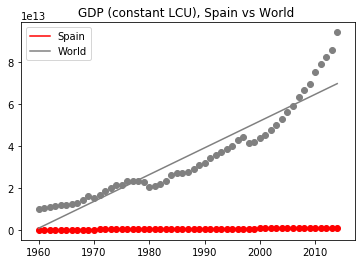

In [10]:
def Draw_Difference(IndicatorName,CountryCode1, CountryCode2):
    """ Draw difference between a country and the rest of the world"""
    CountryCode = CountryCode1
    conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')
    df = pd.read_sql(f"""SELECT CountryName,IndicatorName,IndicatorCode,Year,Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode   = '{CountryCode}'  """,
               conn)

    length = df.shape[0]
    large_name  = df.CountryName.values[0]

    x = df['Year' ].values
    y = df['Value'].values
    x = x.reshape(length,1)
    y = y.reshape(length,1)
    fig = plt.figure()
    plt.scatter(x,y,color='red')
    regr = LinearRegression()
    regr.fit(x,y)
    plt.plot(x,regr.predict(x),color='red',label=f'{large_name}')
    otro =  pd.read_sql(f"""SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode != '{CountryCode}' 
                     AND CountryCode = '{CountryCode2}' 
                     group by Year""",
               conn)
    
    if otro.shape[0] == 0 :
        print(f"vacio, {IndicatorName}")
        otro =  pd.read_sql(f"""SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
               FROM Indicators
               WHERE IndicatorName = '{IndicatorName}' 
                 AND CountryCode != '{CountryCode}' 
                group by Year""",
           conn)
    
    length = otro.shape[0]

    x = otro['Year' ].values
    y = otro['Value'].values
    x = x.reshape(length,1)
    y = y.reshape(length,1)
    regr = LinearRegression()
    regr.fit(x,y)

    # Get Large name for the title
    CountryName2 = pd.read_sql(f"""SELECT CountryName
               FROM Indicators
               WHERE CountryCode = '{CountryCode2}'
               LIMIT 1""",
           conn).values[0][0]
    
    plt.title(f"{IndicatorName}, {large_name} vs {CountryName2} ")
    plt.scatter(x,y,color='gray')
    plt.plot(x,regr.predict(x),color='gray',label=f'{CountryName2}')
    plt.legend(loc=2)

    return plt ,df,otro

IndicatorName  = 'GDP (constant LCU)'
CountryCode1   = 'ESP'
CountryCode2   = 'WLD'

plt ,df,otro = Draw_Difference(IndicatorName,CountryCode1,CountryCode2)
df


In [11]:
IndicatorName = 'GDP (constant LCU)'
CountryCode   = 'ESP'

df = pd.read_sql(f"""SELECT CountryName,IndicatorName,IndicatorCode,Year,Value
               FROM Indicators
               WHERE IndicatorName = '{IndicatorName}' 
                 AND CountryCode   = '{CountryCode}'  """,
           conn)

length = df.shape[0]


In [12]:
slope , intercept , r_value ,p_value,std_err = spstats.linregress(df.Year,df.Value)

In [13]:
print(slope , intercept , r_value ,p_value,std_err)

17709874096.524055 -34558461204175.832 0.9860319284493773 6.114889802252873e-43 410911125.0354207


In [29]:

import traceback
def get_comparision_df(CountryCode1,CountryCode2,filter_indicator='%',DEBUG=False):
    """ Compare two countries with a specific filter"""
    result_array = []
    df_result = pd.DataFrame()

    # We extract indicator from
    df_indicators = pd.read_sql(f"""
                   SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = '{CountryCode1}'
                          AND IndicatorName LIKE  '%{filter_indicator}%' """,
               conn)
    if DEBUG : print(f"""SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = '{CountryCode1}'
                          AND IndicatorName LIKE  '%{filter_indicator}%' """)
    df_world = pd.read_sql(f"""
                  SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode   = '{CountryCode2}' 
                          AND IndicatorName LIKE  '%{filter_indicator}%'""",
               conn)
    if DEBUG : print(f"""2 : SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode   = '{CountryCode2}' 
                          AND IndicatorName LIKE  '%{filter_indicator}%' """)
    
    indicators_array = df_indicators.IndicatorName.values
    world_array      = df_world.IndicatorName.values
    indicator_array  = set(indicators_array) & set( world_array)
    indicator_array_size = len (indicator_array)
    if DEBUG : print(f"""Indicadores::: df_indicators,{df_indicators.shape}, df_world,{df_world.shape}, indicator_array_size,{indicator_array_size}""")
    # Get Diferences between a country and the rest
    for IndicatorName in indicators_array :
        try :
            SQL=  f"""
                SELECT
                A.Year AS Year,
                A.Value as 'Value_{CountryCode2}',
                B.Value as 'Value_{CountryCode1}'
                FROM 
                  ( SELECT Year,Value, CountryName  FROM Indicators WHERE IndicatorName = '{IndicatorName}' AND CountryCode = '{CountryCode2}' ) A   ,
                  ( SELECT Year,Value, CountryName  FROM Indicators WHERE IndicatorName = '{IndicatorName}' AND CountryCode = '{CountryCode1}') B 
                WHERE A.Year = B.Year """ 
            df_values =  pd.read_sql(SQL,conn)
            #Year	Value_EMU	Value_ESP
            length = df_values.shape[0]
            if length < 3 : 
                if DEBUG : print(f"df_values: {IndicatorName} not enough common values  {length} ,to evaluate properly")
                continue
                    
            x = df_values[['Year','Value_'+CountryCode2]].values
            #x              = otro[['Year','Value']].values
            min_max_scaler = preprocessing.MinMaxScaler()
            otro_scaled    = min_max_scaler.fit_transform(x)
            x_otro         = [ point[1] for point in otro_scaled ]

            #x = df[['Year','Value']].values
            x = df_values[['Year','Value_'+CountryCode1]].values

            df_scaled = min_max_scaler.fit_transform(x)
            x_df         = [ point[1] for point in df_scaled ]


            #dst = distance.cosine(df.Value,otro.Value)
            dst = distance.cosine(x_otro,x_df)

            result_array.append({ 
                "value"          : dst, 
                "CountryCode"    : CountryCode1 , 
                'CountryCompare' : CountryCode2 , 
                "IndicatorName"  : IndicatorName  } )
            
        except Exception as e : 
            print(IndicatorName,e)
    df_result = pd.DataFrame(result_array) 

    length = df_result.shape[0]
    if DEBUG : print(df_result.columns,length)

    if length == 0 : 
        if DEBUG : print(f"Vacio: {IndicatorName} al the end")
        return None
    df_result = df_result[df_result['value'].notna()]
    df_result = df_result.sort_values('value')
    return df_result

IndicatorName = 'GDP (constant LCU)'
CountryCode   = 'ESP'

df_result = get_comparision_df('ESP','EMU','%',False)
df_result


/Users/jaimevalero/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/jaimevalero/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/jaimevalero/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/jaimevalero/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/jaimevalero/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/User

,value,CountryCode,CountryCompare,IndicatorName
618,0.000031,ESP,EMU,Profit tax (% of commercial profits)
414,0.000038,ESP,EMU,"Mortality rate, infant, male (per 1,000 live b..."
413,0.000057,ESP,EMU,"Mortality rate, infant, female (per 1,000 live..."
416,0.000084,ESP,EMU,"Mortality rate, under-5, female (per 1,000 liv..."
527,0.000139,ESP,EMU,Fixed broadband subscriptions
423,0.000142,ESP,EMU,PFC gas emissions (thousand metric tons of CO2...
428,0.000158,ESP,EMU,Prevalence of anemia among pregnant women (%)
417,0.000179,ESP,EMU,"Mortality rate, under-5, male (per 1,000 live ..."
531,0.000196,ESP,EMU,"Smoking prevalence, females (% of adults)"
532,0.000206,ESP,EMU,"Smoking prevalence, males (% of adults)"


In [30]:
df_result.shape
#553.4

(605, 4)

# Why Spain is NOT different to euro zone

We print those indicators with the lowers cosine distance

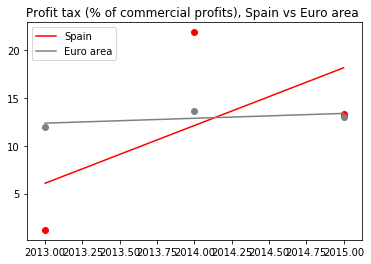

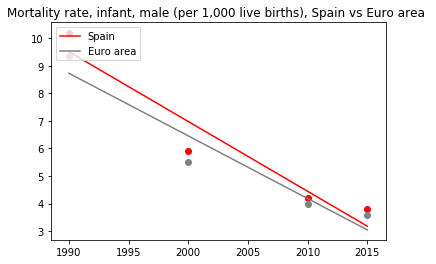

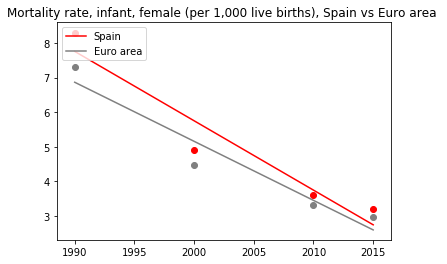

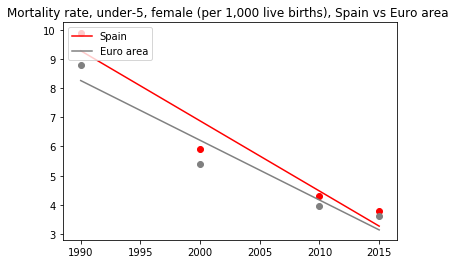

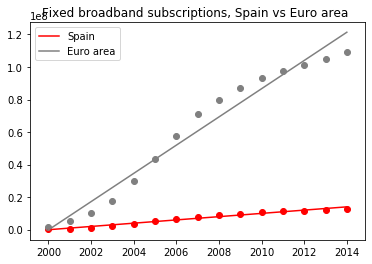

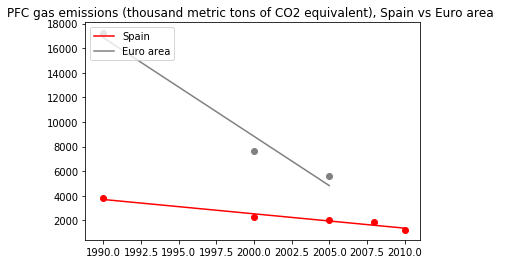

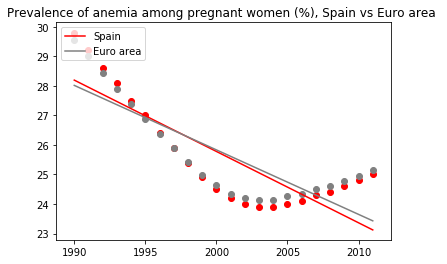

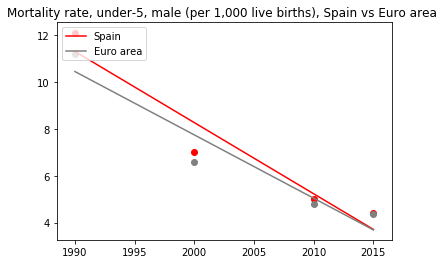

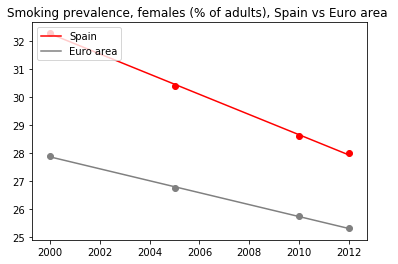

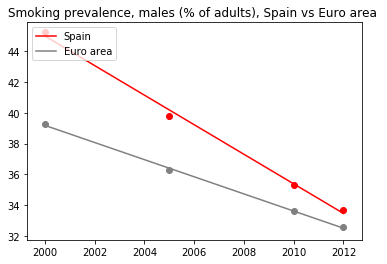

In [31]:
SIMILARITIES_TO_SHOW=10
CountryCompare = df_result.CountryCompare.values[0]
for IndicatorName in df_result.head(SIMILARITIES_TO_SHOW).IndicatorName.values :
        plt ,df_country,df_rest = Draw_Difference(IndicatorName,CountryCode,CountryCompare)


        

# Why Spain is different to euro zone

We draw those indicators with the highest cosine distance


<ipython-input-10-3fc13efc718b>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-10-3fc13efc718b>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-10-3fc13efc718b>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-10-3fc1

<ipython-input-10-3fc13efc718b>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-10-3fc13efc718b>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-10-3fc13efc718b>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-10-3fc1

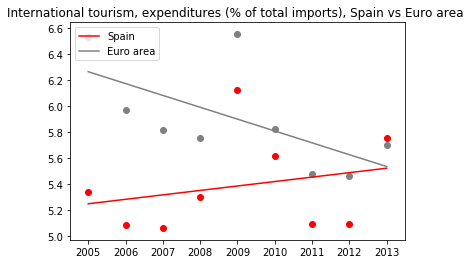

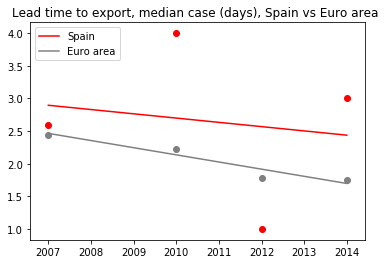

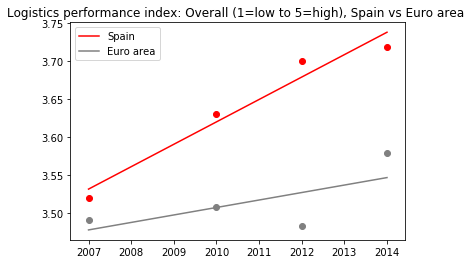

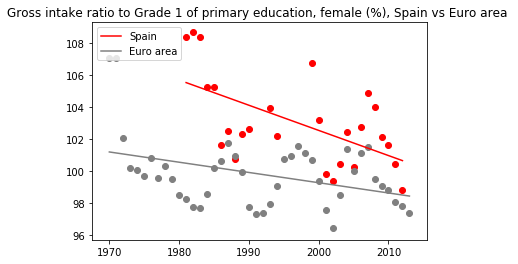

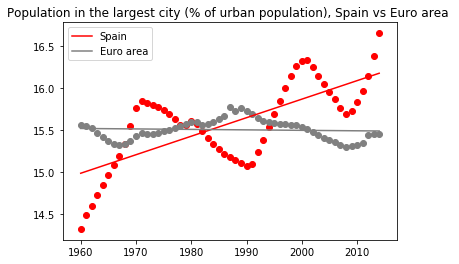

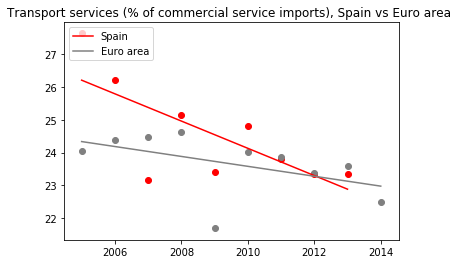

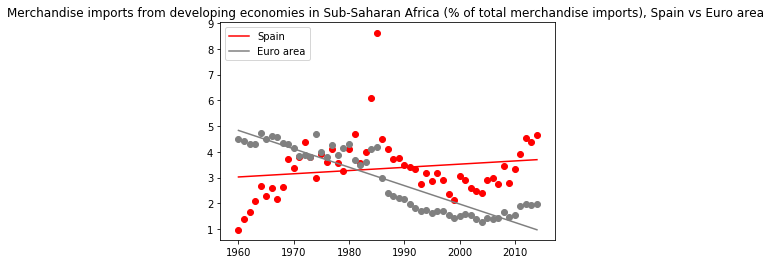

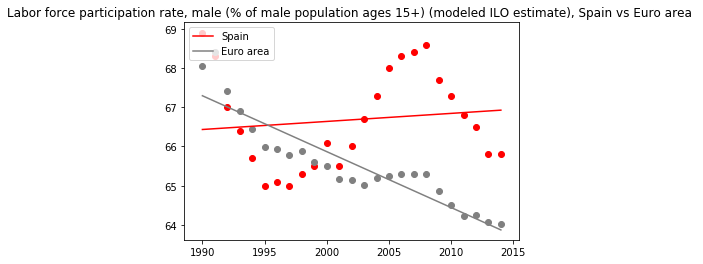

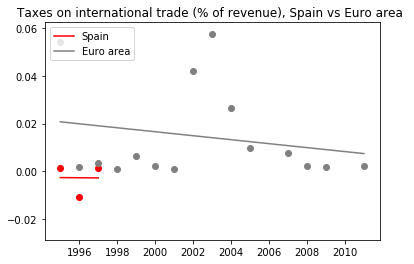

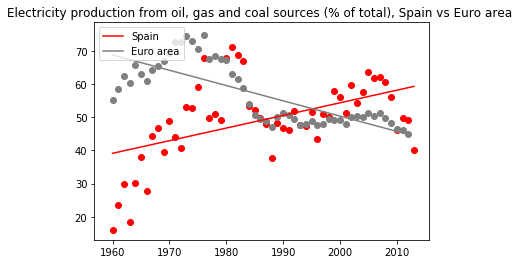

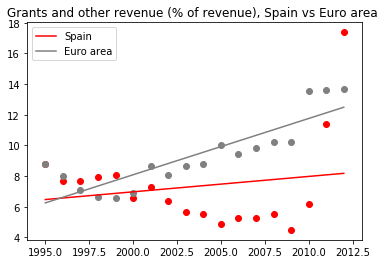

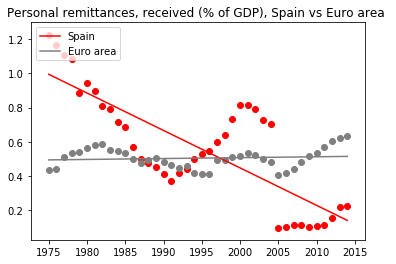

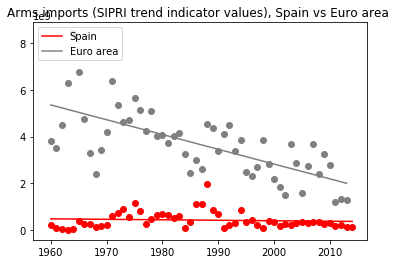

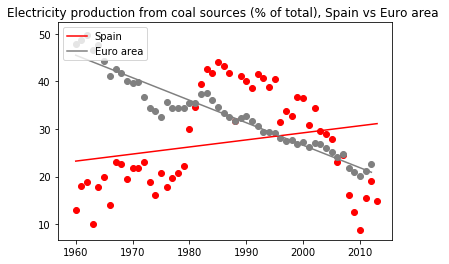

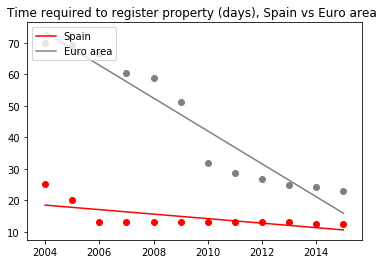

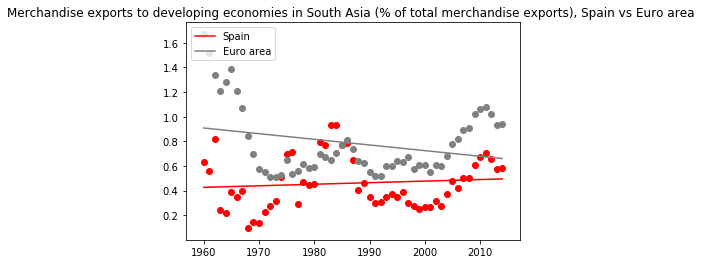

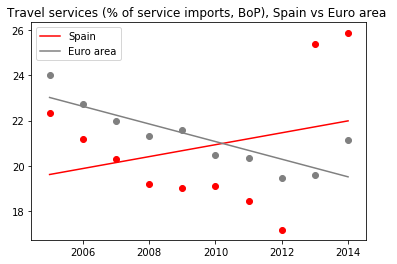

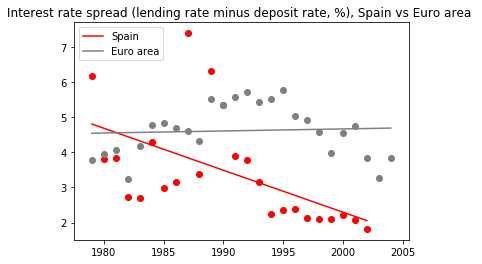

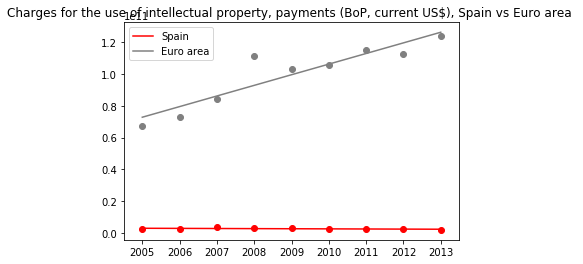

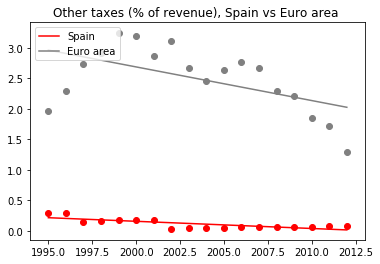

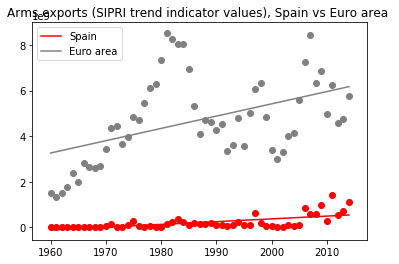

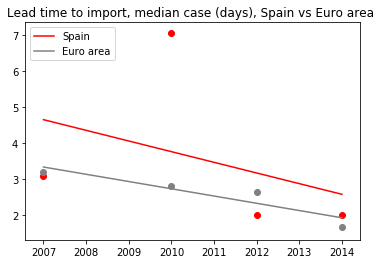

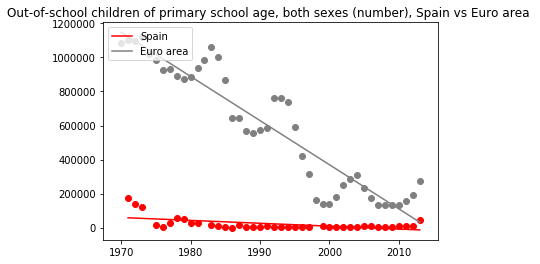

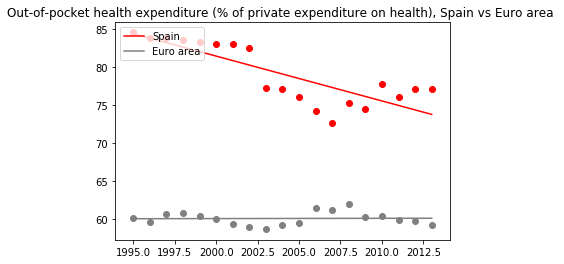

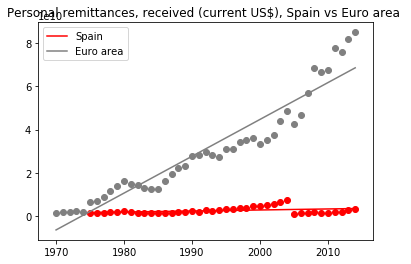

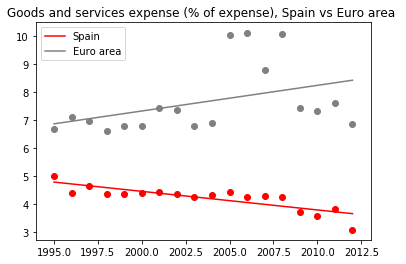

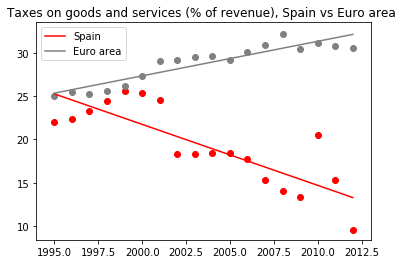

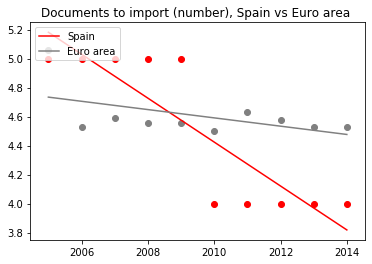

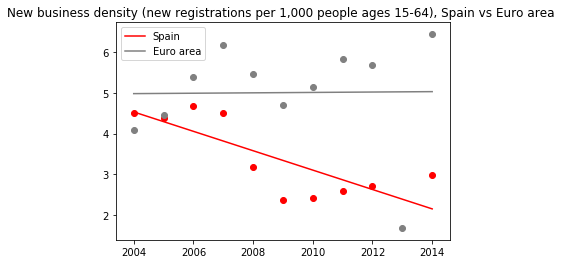

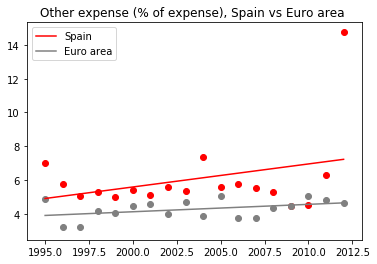

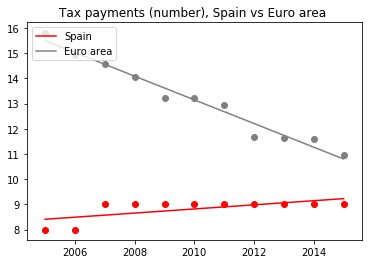

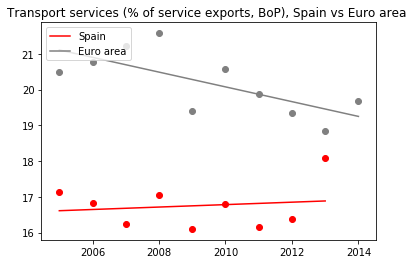

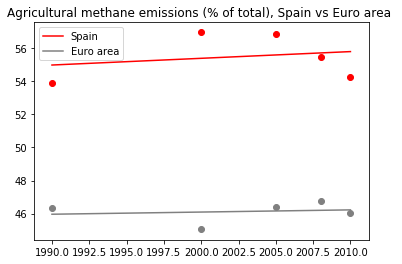

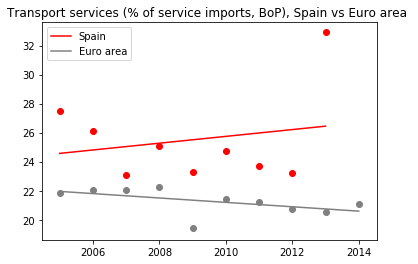

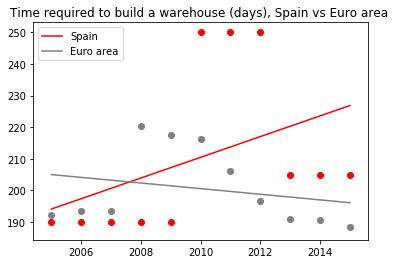

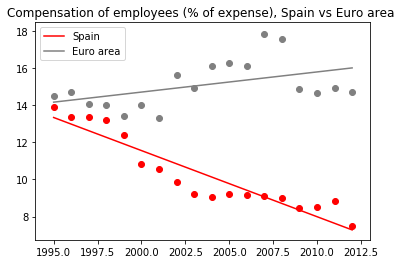

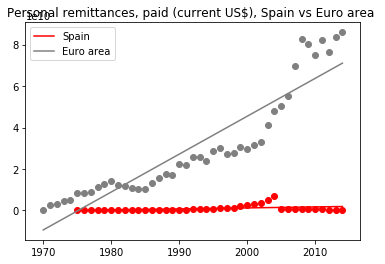

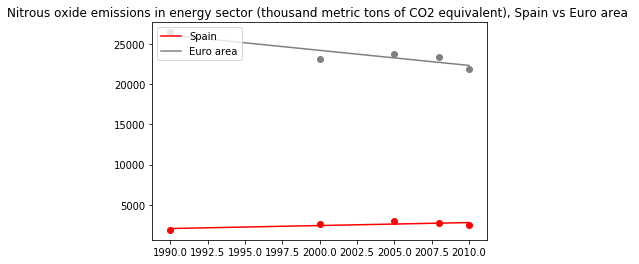

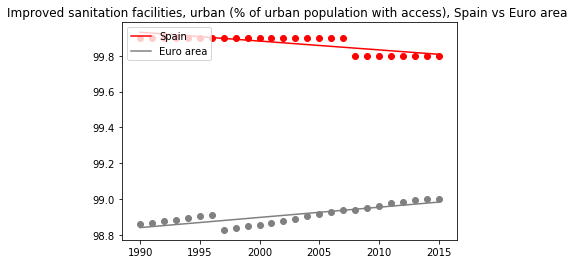

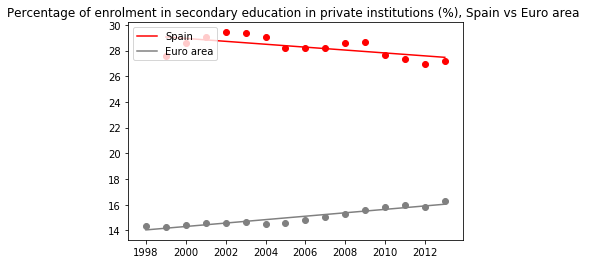

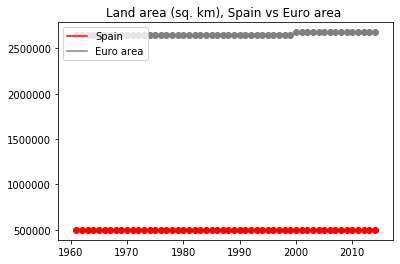

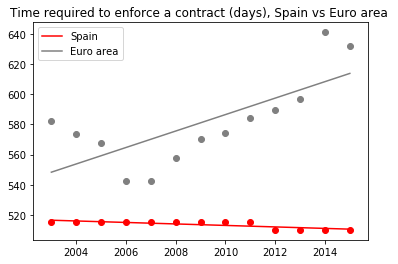

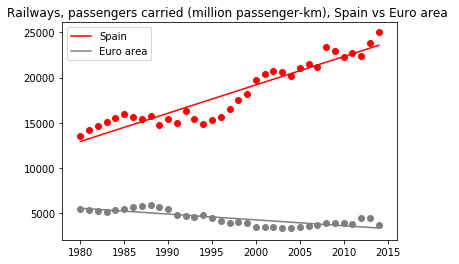

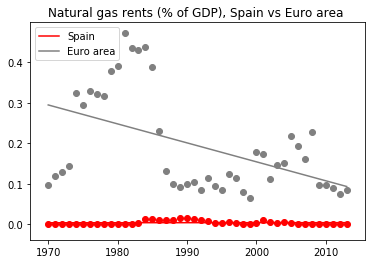

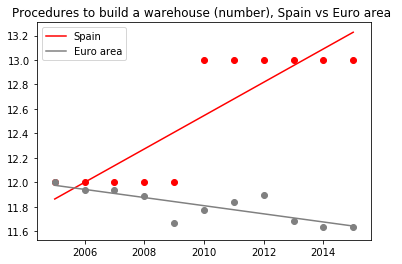

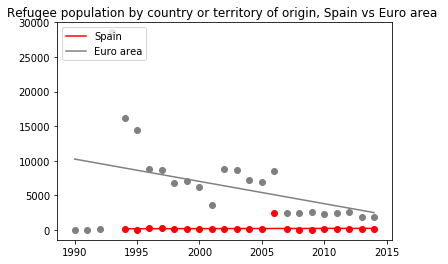

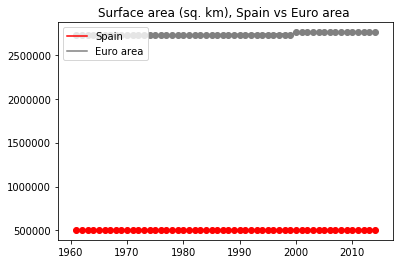

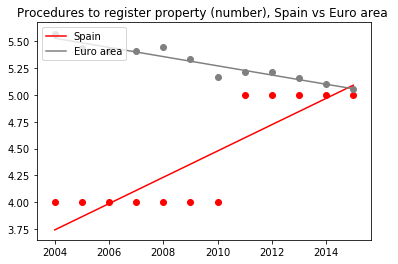

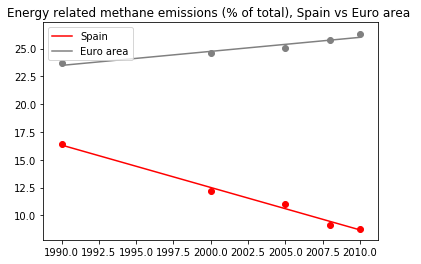

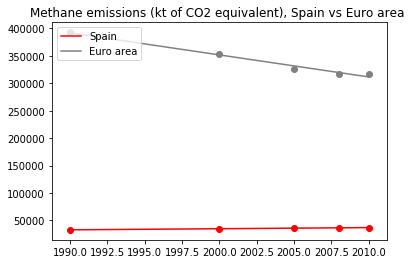

In [32]:
CountryCompare = df_result.CountryCompare.values[0]

for IndicatorName in df_result.tail(50).IndicatorName.values :
    try:
        plt ,df_country,df_rest = Draw_Difference(IndicatorName,CountryCode,CountryCompare)
    except :
        pass


In [23]:
# Debug only
conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')
IndicatorName = 'Percentage of teachers in primary education who are female (%)'
CountryCode2 = 'EMU'
CountryCode1 = 'ESP'
SQL=  f"""
SELECT
    A.Year AS Year,
    A.Value as 'Value_{CountryCode2}',
    B.Value as 'Value_{CountryCode1}'
    FROM 
      ( SELECT Year,Value, CountryName  FROM Indicators WHERE IndicatorName = '{IndicatorName}' AND CountryCode = '{CountryCode2}' ) A   ,
      ( SELECT Year,Value, CountryName  FROM Indicators WHERE IndicatorName = '{IndicatorName}' AND CountryCode = '{CountryCode1}') B 
    WHERE A.Year = B.Year """ 

otro =  pd.read_sql(SQL,conn)
otro

,Year,Value_EMU,Value_ESP
0,1971,72.365547,58.078660
1,1981,73.530769,67.462150
2,1982,73.534920,70.241630
3,1983,74.503532,67.670260
4,1984,75.794563,68.468480
5,1986,75.961441,68.635850
6,1987,76.163063,70.462530
7,1988,76.133301,69.968570
8,1990,77.265038,72.880790
9,1991,78.074097,72.713500


In [38]:
df_result.head(2)

,value,CountryCode,CountryCompare,IndicatorName
618,0.000031,ESP,EMU,Profit tax (% of commercial profits)
414,0.000038,ESP,EMU,"Mortality rate, infant, male (per 1,000 live b..."


In [116]:
df_result.query( 'IndicatorName.str.contains("Prod")', engine = 'python'  )

,value,CountryCode,CountryCompare,IndicatorName


In [ ]:
CountryCode2 = 'EMU'
CountryCode1 = 'ESP'

# Minimal Year
SQL=  f""" SELECT min(Year) AS Year , CountryCode FROM Indicators WHERE IndicatorName = '{IndicatorName}' AND  ( CountryCode   = '{CountryCode1}' OR  CountryCode   = '{CountryCode2}') group by CountryCode order by Year desc limit 1  """
minyear =  pd.read_sql(SQL,conn).Year.iloc[0]
# MAximal Year
SQL=  f""" SELECT max(Year) AS Year , CountryCode FROM Indicators WHERE IndicatorName = '{IndicatorName}' AND  ( CountryCode   = '{CountryCode1}' OR  CountryCode   = '{CountryCode2}') group by CountryCode  order by Year asc limit 1  """
maxyear =  pd.read_sql(SQL,conn).Year.iloc[0]

SQL=  f"""
                SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode   = '{CountryCode1}' 
                     AND Year >= {minyear}
                     AND Year <= {maxyear}
                   GROUP Year,IndicatorName,IndicatorCode
                   ORDER BY Year asc """
print(SQL)
otro =  pd.read_sql(SQL,conn)
otro

'GDP per capita, PPP (constant 2011 international $)'

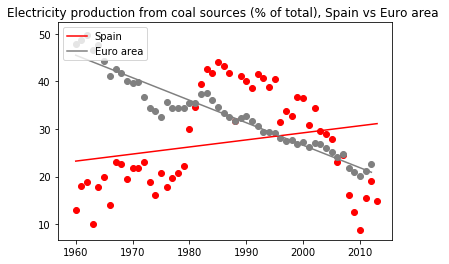

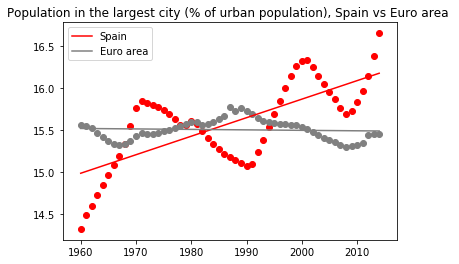

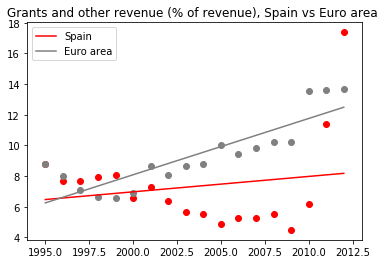

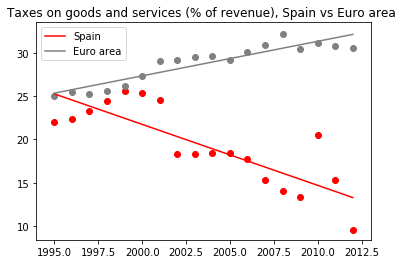

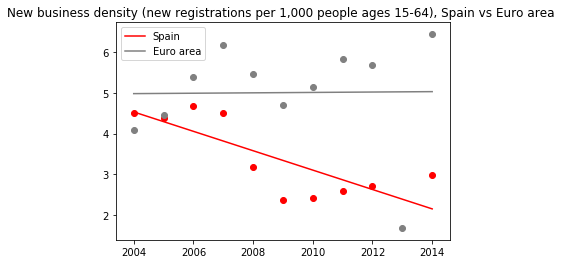

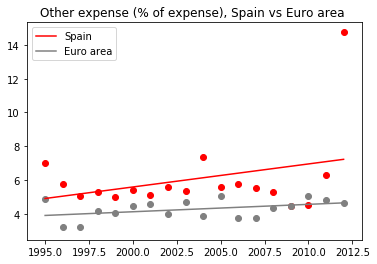

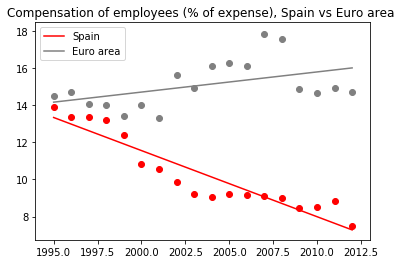

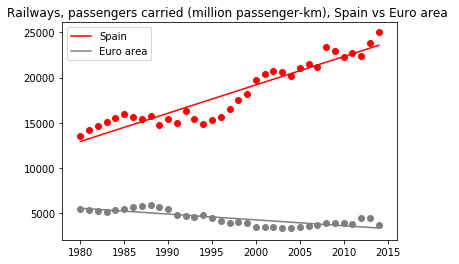

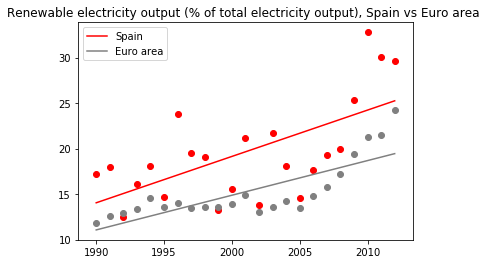

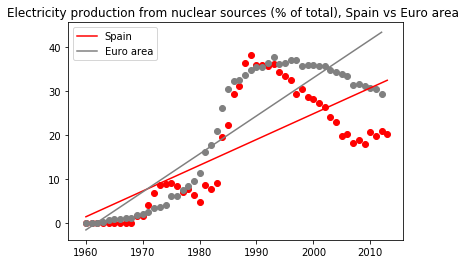

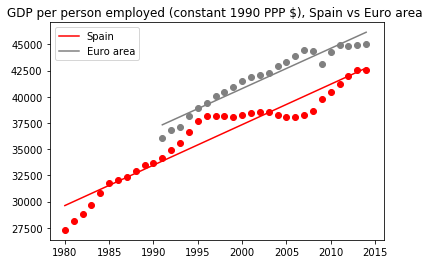

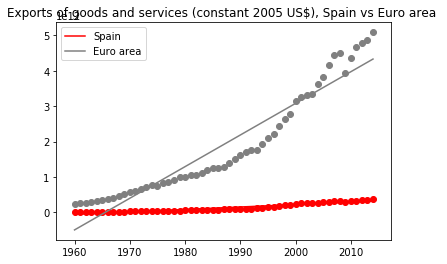

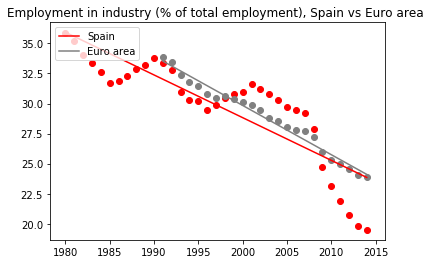

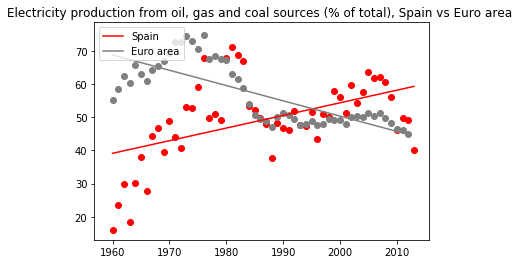

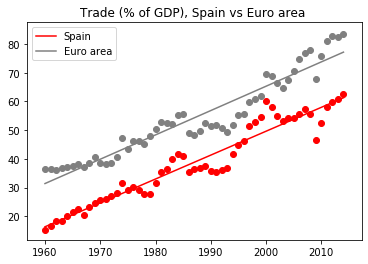

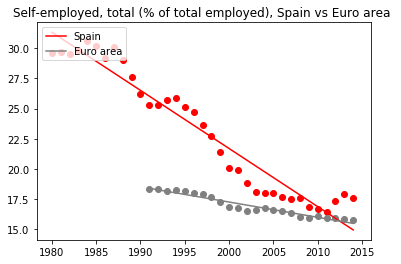

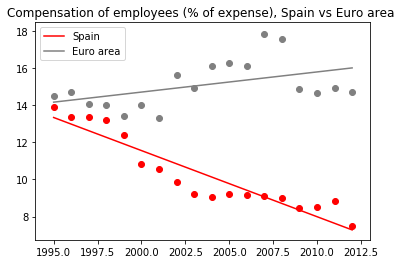

In [172]:
INDICATORS_ARRAY = ['Electricity production from coal sources (% of total)',
'Population in the largest city (% of urban population)',
'Grants and other revenue (% of revenue)',
'Taxes on goods and services (% of revenue)',
'New business density (new registrations per 1,000 people ages 15-64)',
'Other expense (% of expense)',
'Compensation of employees (% of expense)',
'Railways, passengers carried (million passenger-km)',
'Renewable electricity output (% of total electricity output)',
'Electricity production from nuclear sources (% of total)',
'GDP per person employed (constant 1990 PPP $)',
'Exports of goods and services (constant 2005 US$)',
'Employment in industry (% of total employment)',
'Electricity production from oil, gas and coal sources (% of total)',
'Trade (% of GDP)',
'Self-employed, total (% of total employed)',
'Compensation of employees (% of expense)' ]
CountryCode1   = 'ESP'
CountryCode2   = 'EMU'

for IndicatorName in INDICATORS_ARRAY:
    plt ,df,otro = Draw_Difference(IndicatorName,CountryCode1,CountryCode2)
# not had changed
'GNI per capita, Atlas method (current US$)'
'GDP per capita, PPP (constant 2011 international $)'

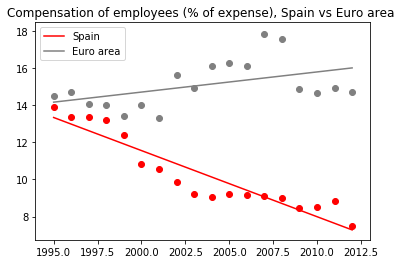

In [114]:
IndicatorName  ='Compensation of employees (% of expense)'
CountryCode1   = 'ESP'
CountryCode2   = 'EMU'

plt ,df,otro = Draw_Difference(IndicatorName,CountryCode1,CountryCode2)


In [ ]:
REMOVE_COUNTRIES_CLUSTERS ="""
   ( 
      CountryCode != 'WLD' AND     CountryCode != 'LMY' AND     CountryCode != 'MIC' AND     CountryCode != 'LMC' AND     CountryCode != 'UMC' AND     CountryCode != 'EAS' AND     CountryCode != 'EAP' AND     CountryCode != 'SAS' AND     CountryCode != 'HIC' AND     CountryCode != 'OED' AND     CountryCode != 'OEC' AND     CountryCode != 'SSF' AND     CountryCode != 'SSA' AND     CountryCode != 'LDC' AND     CountryCode != 'ECS' AND     CountryCode != 'LCN' AND     CountryCode != 'LIC' AND     CountryCode != 'LAC' AND     CountryCode != 'EUU' AND     CountryCode != 'FCS' AND     CountryCode != 'MEA' AND     CountryCode != 'ARB' AND     CountryCode != 'MNA' AND     CountryCode != 'NAC' AND     CountryCode != 'EMU' AND     CountryCode != 'NOC'   AND     CountryCode != 'ECA' AND     CountryCode != 'HPC' 
    )
"""

# Indicators where Spain top ranks (for good or bad)

In [171]:
### Rankings
conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')
CountryCode1   = 'ESP'
limit=10

### For each indicator, last values, for all countries.
arr_rankings = []
for indicator in indicators_array :
    for order in ['asc','desc']:
        #CountryName	CountryCode	IndicatorName	IndicatorCode	Year	Value
        SQL=  f"""
        SELECT CountryName , CountryCode , IndicatorName, Value, MAX(Year) AS 'Year'
        FROM   Indicators 
        WHERE  IndicatorName = '{indicator}'
               AND {REMOVE_COUNTRIES_CLUSTERS}
        GROUP BY CountryCode, CountryName,IndicatorName
        ORDER BY Value {order}
        LIMIT {limit}
        """ 
        df_indicators =  pd.read_sql(SQL,conn)
        df_indicators['ranking'] = df_indicators.index +1 
        df_indicators = df_indicators.query( f'CountryCode == "{CountryCode1}"', engine = 'python'  )
        has_rows = df_indicators.shape[0]
        if has_rows :
            df_indicators['order'] = order+'ending'
            arr_rankings.append(df_indicators)

df_rankings = pd.concat(arr_rankings)
df_rankings = df_rankings.sort_values('ranking')
df_rankings


,CountryName,CountryCode,IndicatorName,Value,Year,ranking,order
0,Spain,ESP,"Unemployment, youth male (% of male labor forc...",5.780000e+01,2014,1,descending
0,Spain,ESP,"Unemployment, youth total (% of total labor fo...",5.790000e+01,2014,1,descending
1,Spain,ESP,"Unemployment, youth male (% of male labor forc...",5.340000e+01,2014,2,descending
1,Spain,ESP,"International tourism, receipts (current US$)",6.760800e+10,2013,2,descending
1,Spain,ESP,"International tourism, receipts for travel ite...",6.038400e+10,2013,2,descending
1,Spain,ESP,Social contributions (% of revenue),5.292438e+01,2012,2,descending
1,Spain,ESP,"Employment to population ratio, ages 15-24, ma...",1.620000e+01,2014,2,ascending
1,Spain,ESP,Income share held by fourth 20%,2.345000e+01,2012,2,descending
2,Spain,ESP,Goods and services expense (% of expense),3.105456e+00,2012,3,ascending
3,Spain,ESP,"Life expectancy at birth, female (years)",8.550000e+01,2013,4,descending


In [ ]:
#

In [168]:
# DEBUG only
indicator = "Population, total"
CountryCode1   = 'CHN'
limit=30
order='desc'

SQL=  f"""
           SELECT CountryName , CountryCode , IndicatorName, Value,MAX(Year) AS 'Year' 
           FROM Indicators WHERE IndicatorName = '{indicator}'
           AND {REMOVE_COUNTRIES_CLUSTERS}
           GROUP BY CountryCode, CountryName,IndicatorName
           ORDER BY Value {order}
           LIMIT {limit}"""
df_remove = pd.read_sql(SQL,conn)
df_remove



,CountryName,CountryCode,IndicatorName,Value,Year
0,China,CHN,"Population, total",1364270000,2014
1,India,IND,"Population, total",1295291543,2014
2,Heavily indebted poor countries (HIPC),HPC,"Population, total",701714118,2014
3,United States,USA,"Population, total",318857056,2014
4,Europe & Central Asia (developing only),ECA,"Population, total",264350728,2014
5,Indonesia,IDN,"Population, total",254454778,2014
6,Brazil,BRA,"Population, total",206077898,2014
7,Pakistan,PAK,"Population, total",185044286,2014
8,Nigeria,NGA,"Population, total",177475986,2014
9,Bangladesh,BGD,"Population, total",159077513,2014


In [167]:

#REMOVE_COUNTRIES_CLUSTERS.replace('=!','!=').replace('\n ',' ')

In [ ]:
df_rankings = pd.concat(arr_rankings)
df_rankings = df_rankings.sort_values('ranking')
df_rankings


# 